<a href="https://colab.research.google.com/github/Manan1811/LSTM--1/blob/master/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [36]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import keras
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Using TensorFlow backend.


In [5]:
path = "/content/drive/My Drive/london_merged.csv"
df= pd.read_csv(path, parse_dates=['timestamp'], index_col='timestamp')
df.head()


,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [6]:
df['hour']=df.index.hour
df['day_of_week']=df.index.dayofweek
df['day_of_month']=df.index.day
df['month']=df.index.month

In [7]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,6,4,1


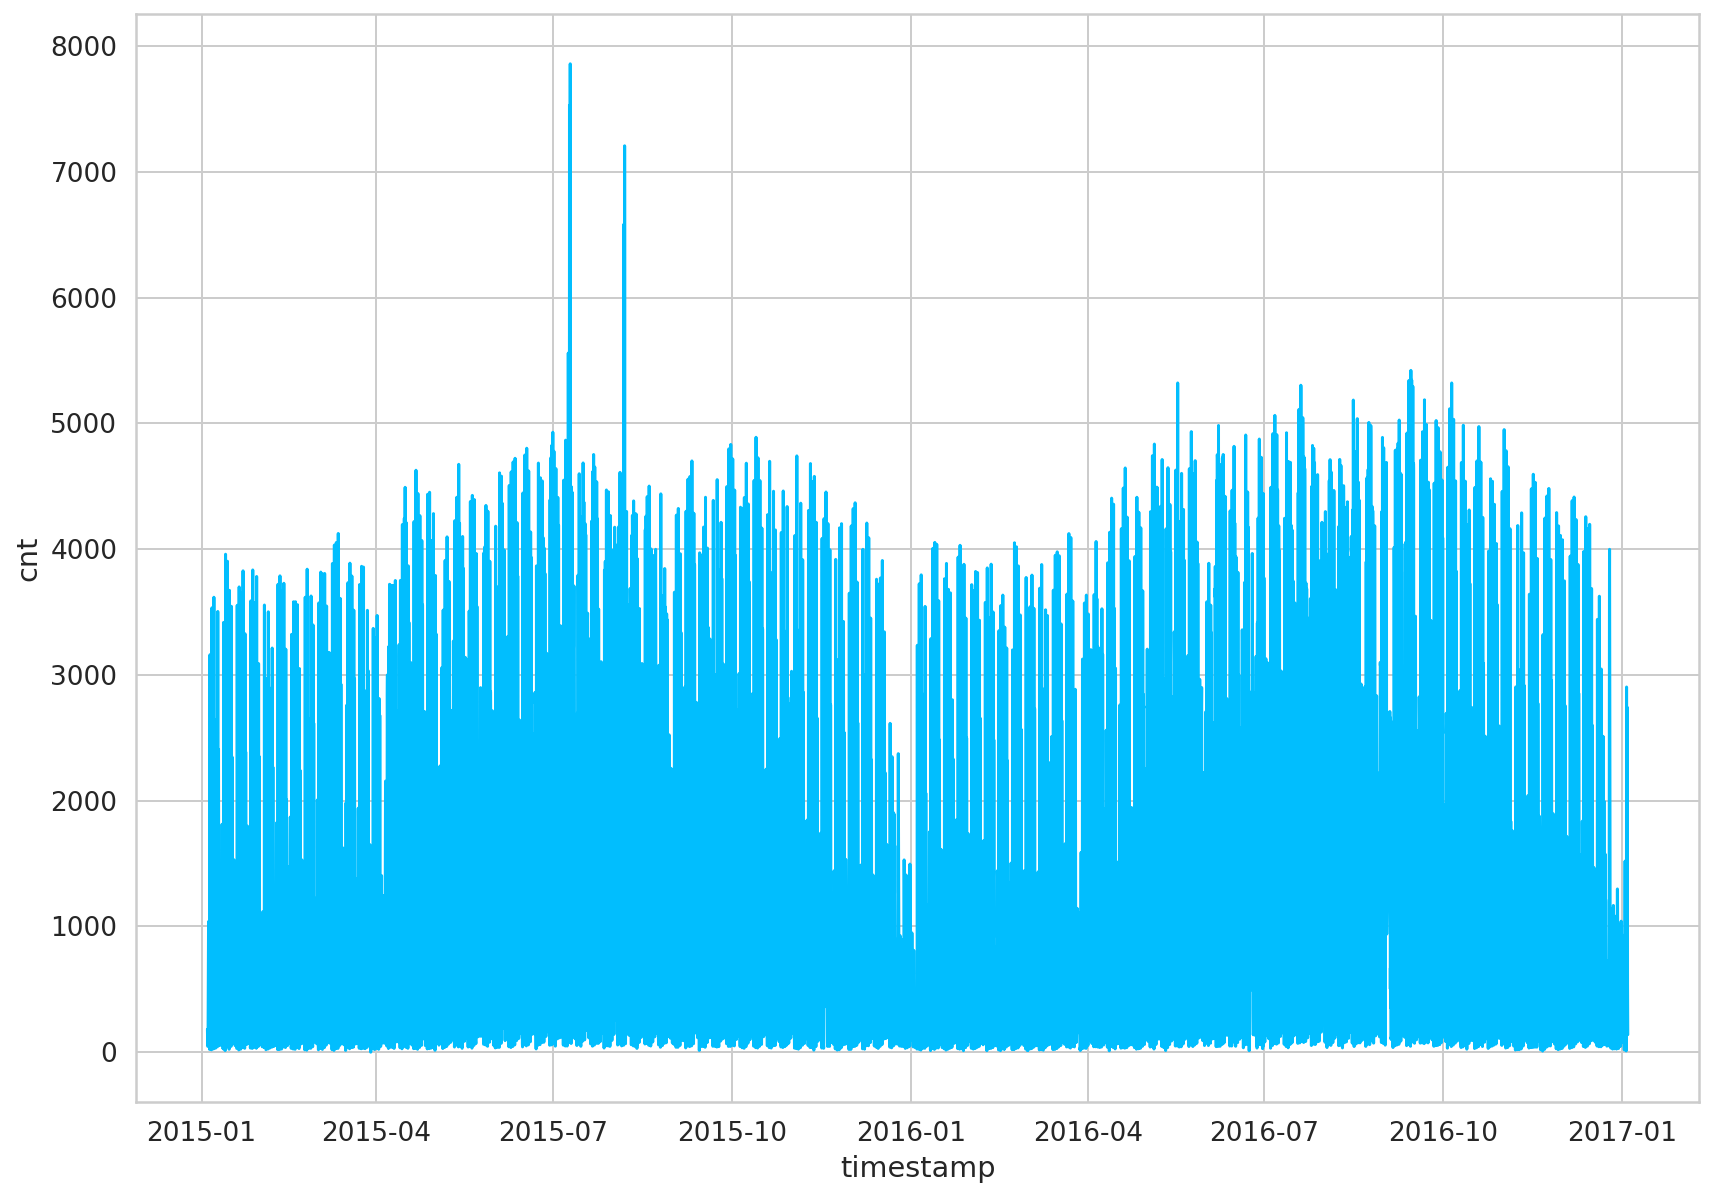

In [8]:
sns.lineplot(x=df.index, y='cnt',data=df)

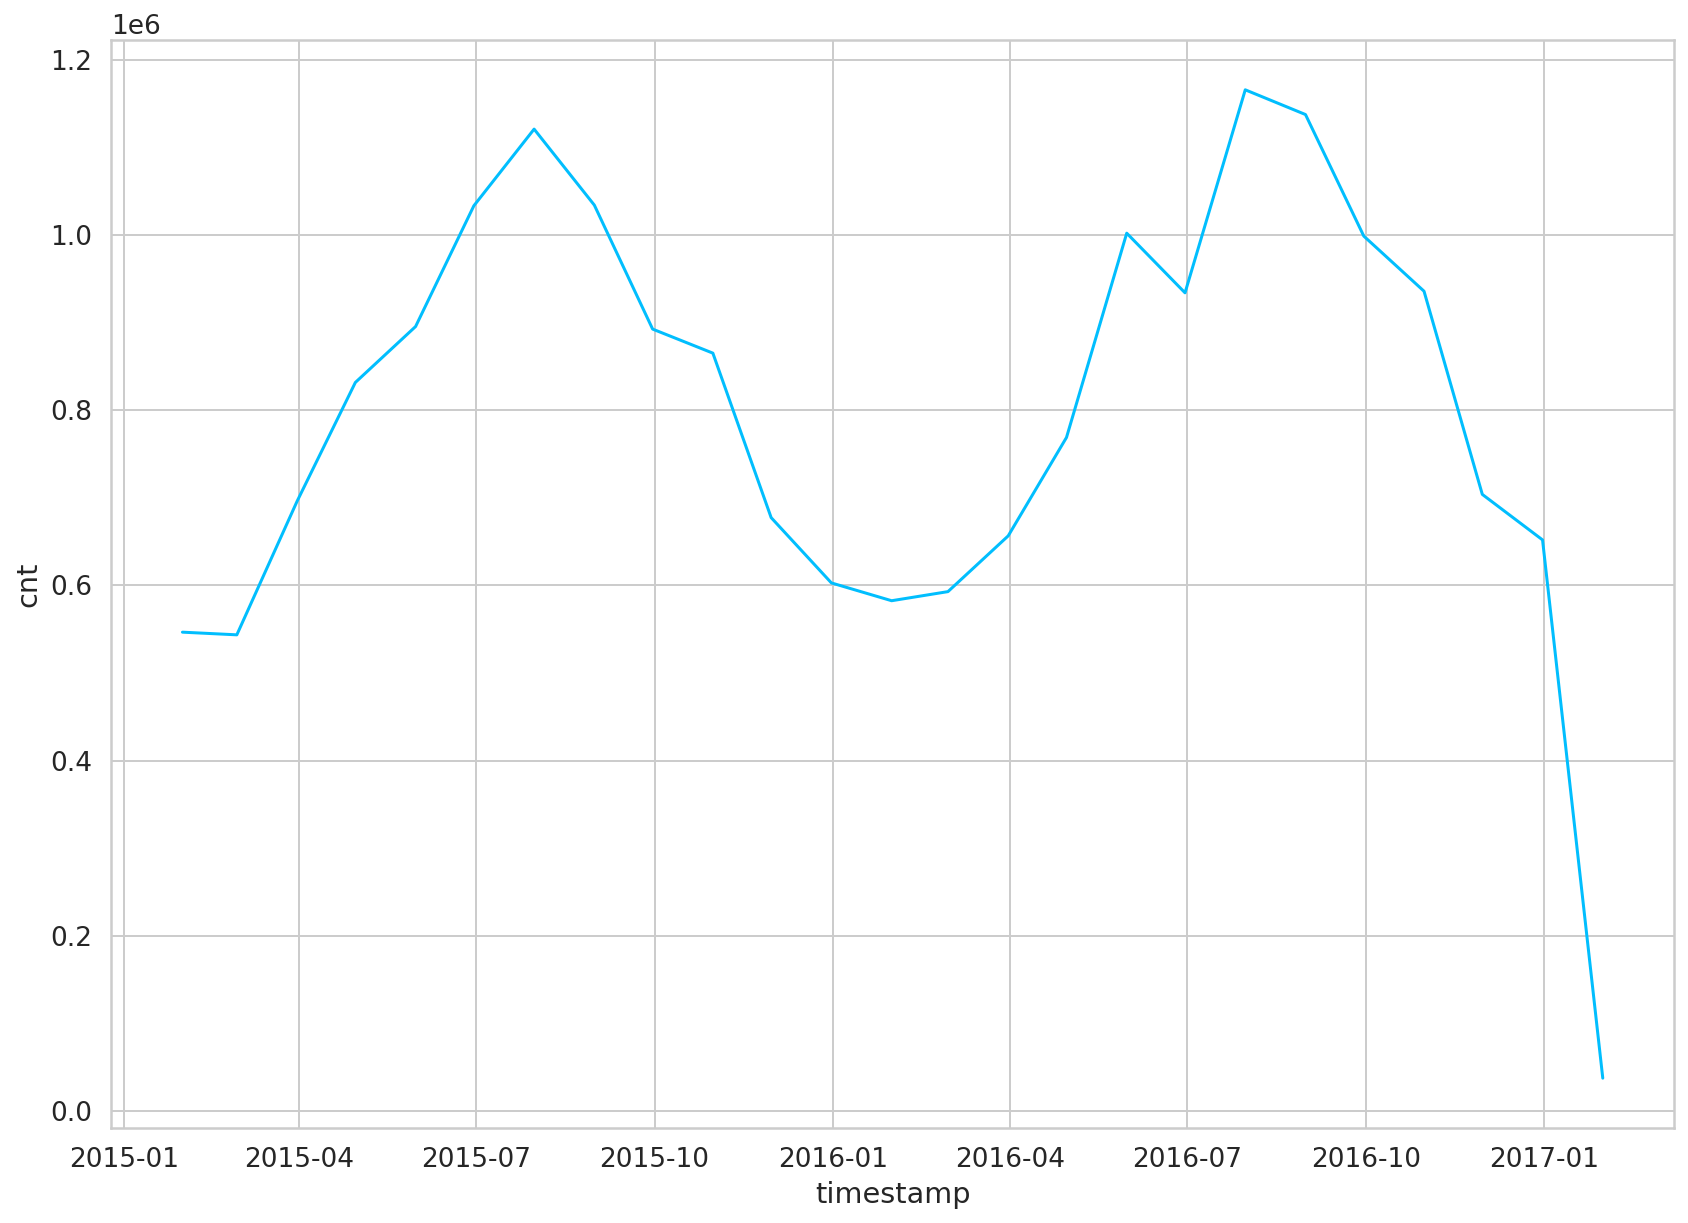

In [10]:
df_by_month=df.resample('M').sum()
sns.lineplot(x=df_by_month.index, y='cnt',data=df_by_month)

In [12]:
df_by_month.head(10)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month
timestamp,,,,,,,,,,,,,
2015-01-31,546639,4101.0,2255.5,51005.00,12502.000000,2211.0,0.0,192.0,2013.0,7709,2014,11753,671
2015-02-28,543594,3721.5,1868.0,51950.00,9873.500000,2409.0,0.0,192.0,2013.0,7707,2015,9734,1342
2015-03-31,695934,6093.5,4558.5,51832.25,12938.250000,1940.0,0.0,215.0,0.0,8540,2174,11751,2217
2015-04-30,831582,7873.0,7112.5,48468.00,10988.500000,1642.0,48.0,191.0,0.0,8270,2131,11156,2876
2015-05-31,895413,10091.5,9803.5,47939.00,14268.500000,1900.0,48.0,240.0,0.0,8556,2376,11904,3720
2015-06-30,1033252,12151.5,12073.0,44371.50,12398.000000,1457.0,0.0,192.0,717.0,8268,2028,11145,4302
2015-07-31,1120687,14107.0,14060.0,46632.50,13067.000000,1710.0,0.0,192.0,740.0,8508,2232,11831,5180
2015-08-31,1033951,13830.5,13816.5,51913.50,10326.000000,1948.0,24.0,240.0,744.0,8556,2280,11904,5952
2015-09-30,892478,10371.0,10357.5,52002.00,9394.000000,1683.0,0.0,185.0,1422.0,8210,2045,11047,6399


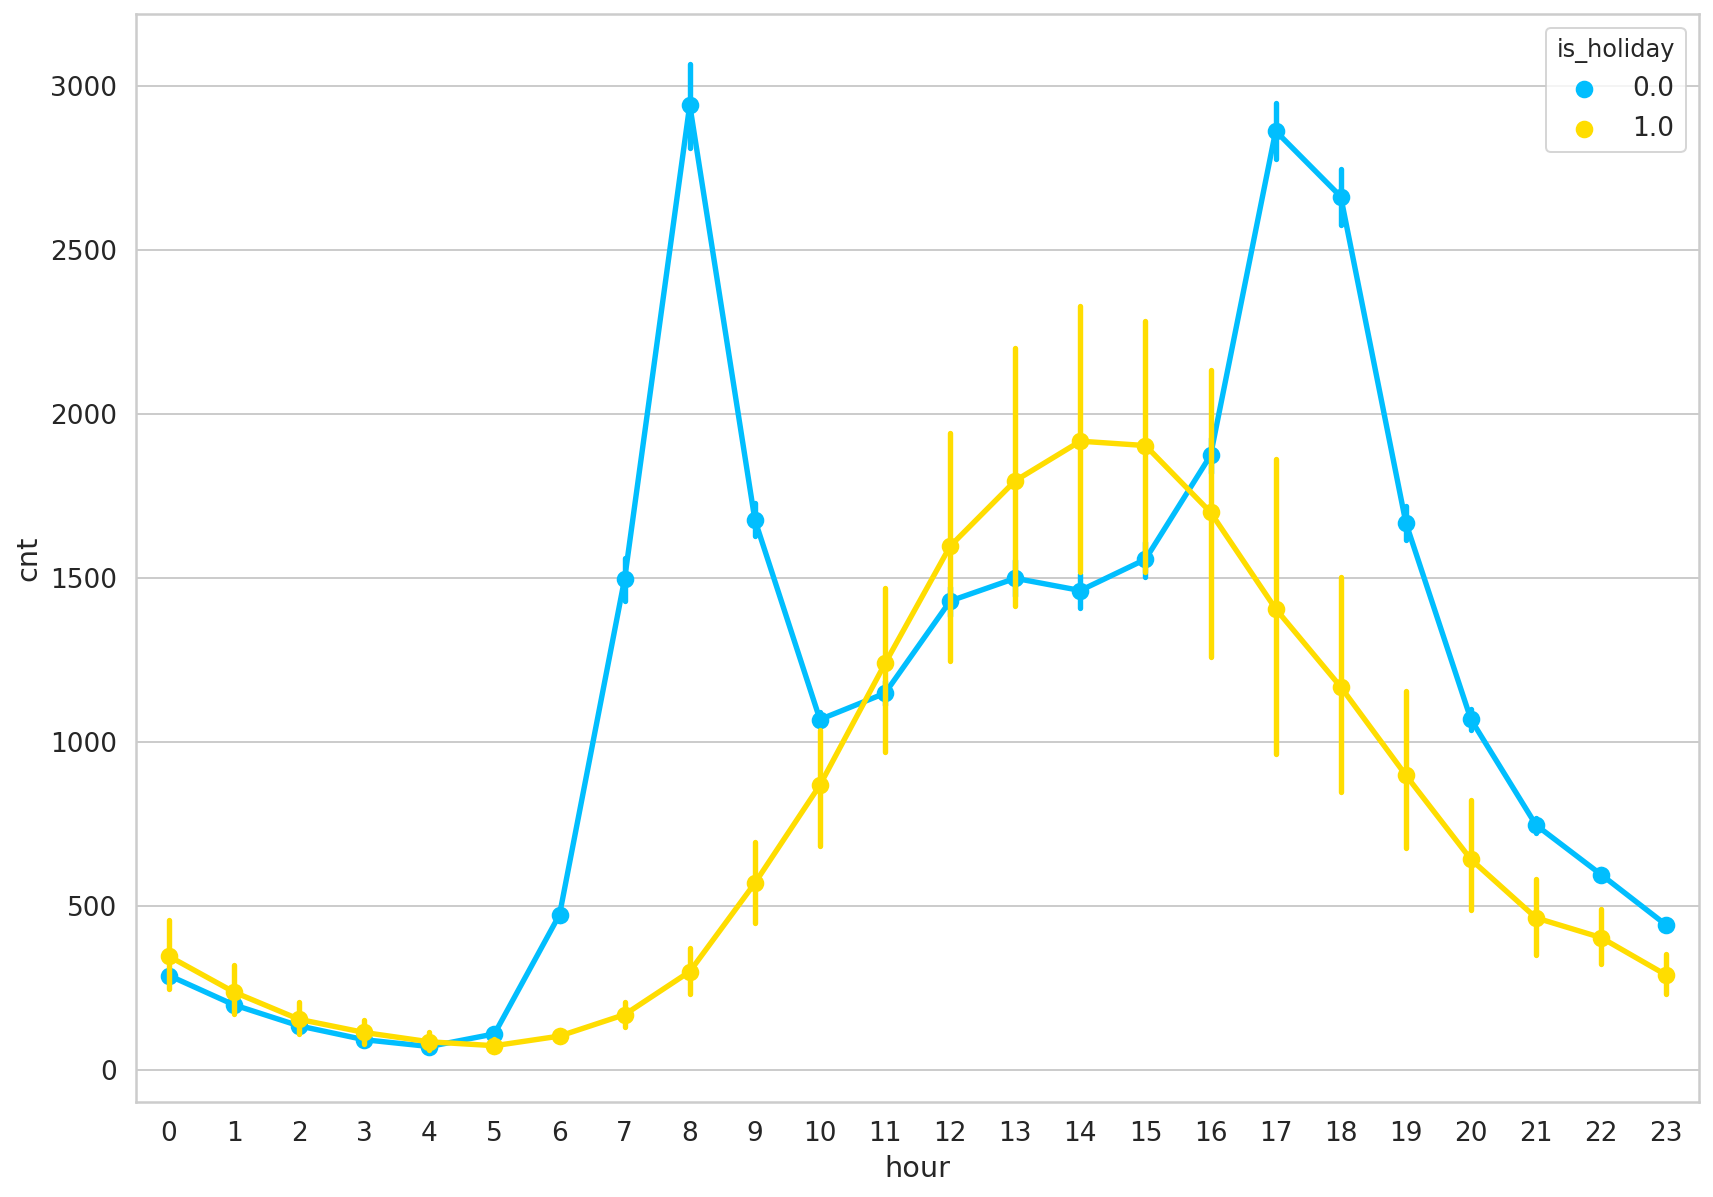

In [16]:
sns.pointplot(x=df['hour'], y='cnt',data=df, hue=df['is_holiday'])

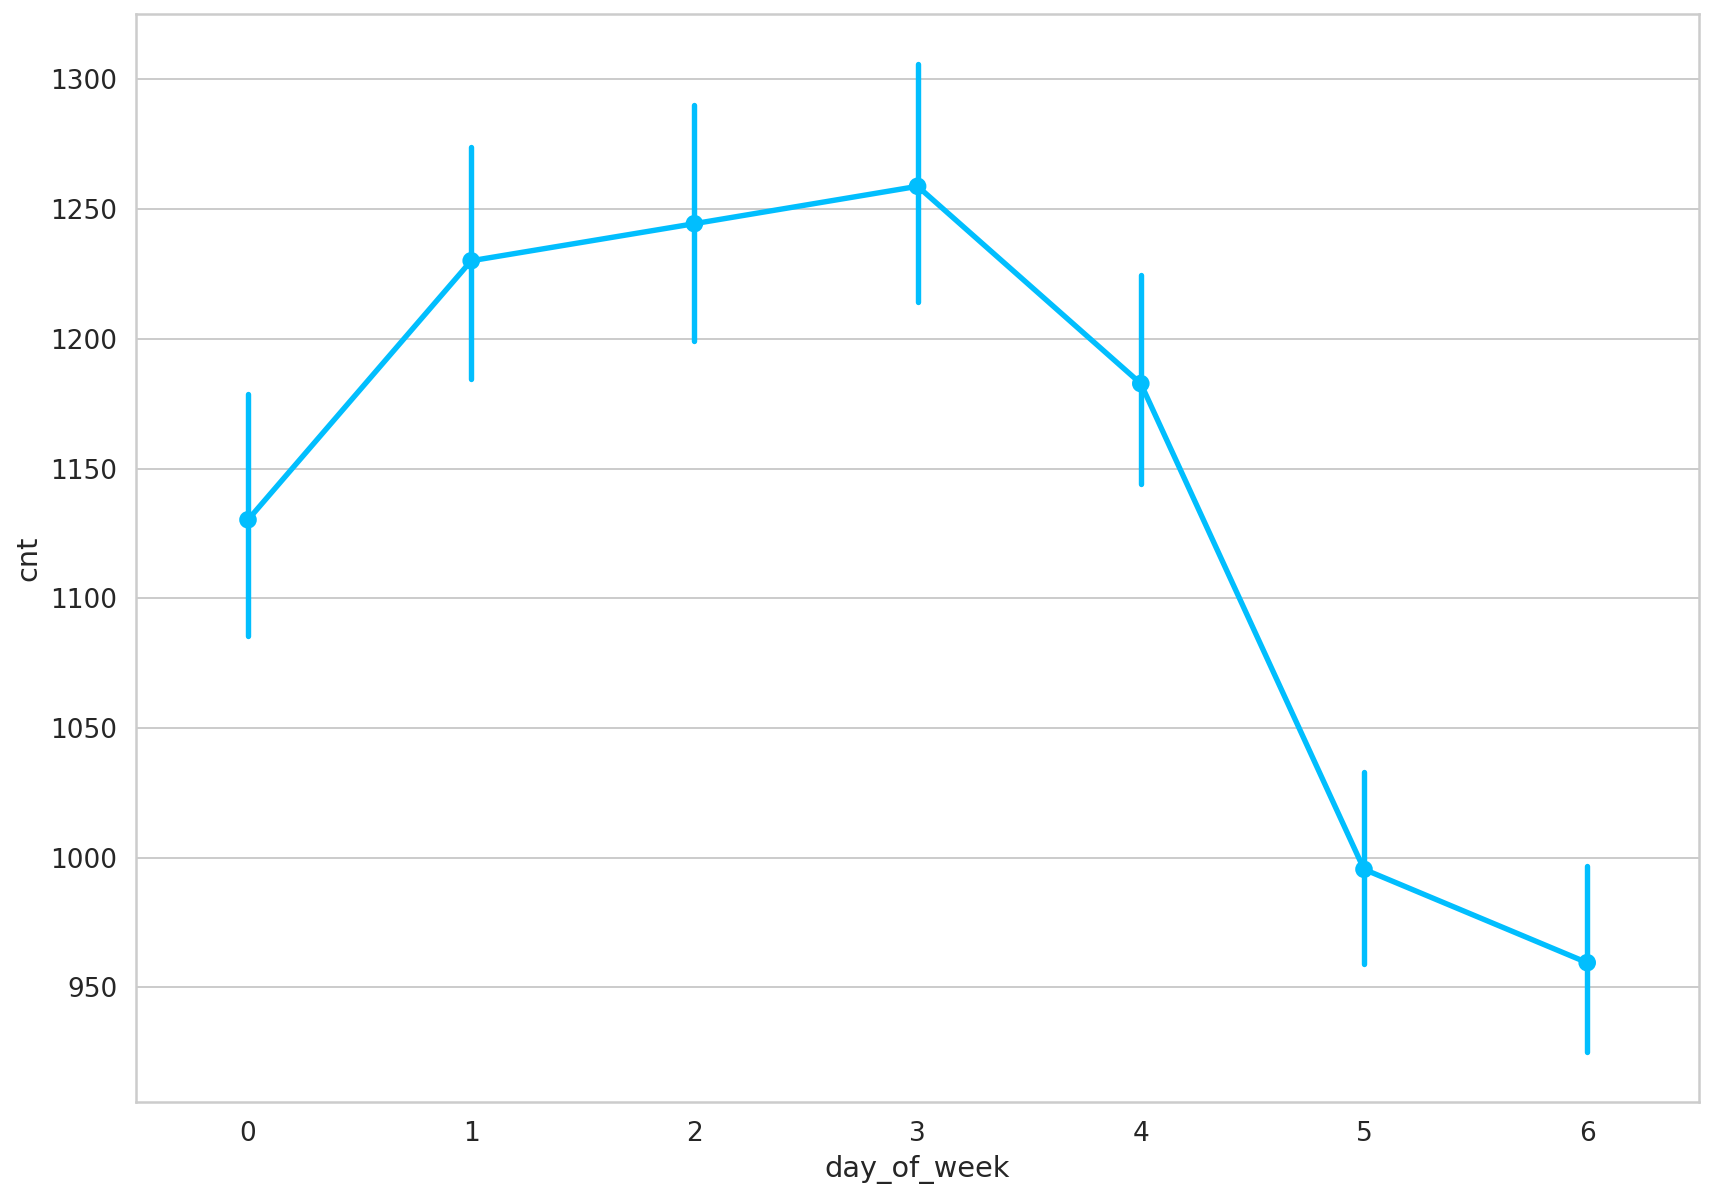

In [17]:
sns.pointplot(x=df['day_of_week'], y='cnt',data=df )

In [19]:
train_size= int(len(df)*0.9)
test_size=len(df)-train_size
train,test= df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(15672, 13) (1742, 13)


In [23]:
train.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,-0.464876,-1.2500,-1.047619,0.975,-0.818182,3.0,0.0,1.0,3.0,0,6,4,1
2015-01-04 01:00:00,-0.495179,-1.2500,-1.000000,0.975,-0.909091,1.0,0.0,1.0,3.0,1,6,4,1
2015-01-04 02:00:00,-0.497934,-1.3125,-1.000000,1.150,-1.363636,1.0,0.0,1.0,3.0,2,6,4,1
2015-01-04 03:00:00,-0.540634,-1.3750,-1.047619,1.325,-1.363636,1.0,0.0,1.0,3.0,3,6,4,1
2015-01-04 04:00:00,-0.557851,-1.3750,-1.238095,0.975,-0.772727,1.0,0.0,1.0,3.0,4,6,4,1


In [22]:
from sklearn.preprocessing import RobustScaler

f_col=['t1', 't2', 'hum', 'wind_speed']

f_transformer=RobustScaler()
cnt_transformer=RobustScaler()

f_transformer= f_transformer.fit(train[f_col].to_numpy())
cnt_transformer= cnt_transformer.fit(train[['cnt']])

train.loc[:,f_col]=f_transformer.transform(train[f_col].to_numpy())
train['cnt']=cnt_transformer.transform(train[['cnt']])

test.loc[:,f_col]=f_transformer.transform(test[f_col].to_numpy())
test['cnt']=cnt_transformer.transform(test[['cnt']])



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [27]:
def create_dataset(X,y,time_steps=1):
    xs = []
    ys = []

    for i in range(len(X)-time_steps):
        v= X.iloc[i:(i+time_steps)].to_numpy()
        xs.append(v)
        ys.append(y.iloc[i+time_steps])

    return np.array(xs), np.array(ys)

In [28]:
Time_Steps=24
X_train,y_train=create_dataset(train,train.cnt,time_steps=Time_Steps)
X_test,y_test=create_dataset(test,test.cnt,time_steps=Time_Steps)

# [samples, time_steps, n_features]
print(X_train.shape, y_train.shape)

(15648, 24, 13) (15648,)


In [29]:
print(X_test.shape, y_test.shape)

(1718, 24, 13) (1718,)


In [33]:
X_test[0][0]

array([-0.37052342,  8.        ,  7.        , 87.        ,  6.        ,
        2.        ,  0.        ,  1.        ,  2.        ,  8.        ,
        6.        , 23.        , 10.        ])

In [37]:
model=keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1],X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))

In [40]:
model.compile(loss='mse', optimizer='adam')

In [41]:
history= model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)

Train on 14083 samples, validate on 1565 samples
Epoch 1/30
14083/14083 [==============================] - 63s 4ms/step - loss: 0.1957 - val_loss: 0.0928
Epoch 2/30
14083/14083 [==============================] - 61s 4ms/step - loss: 0.0657 - val_loss: 0.0398
Epoch 3/30
14083/14083 [==============================] - 61s 4ms/step - loss: 0.0413 - val_loss: 0.0341
Epoch 4/30
14083/14083 [==============================] - 60s 4ms/step - loss: 0.0332 - val_loss: 0.0269
Epoch 5/30
14083/14083 [==============================] - 61s 4ms/step - loss: 0.0286 - val_loss: 0.0600
Epoch 6/30
14083/14083 [==============================] - 61s 4ms/step - loss: 0.0260 - val_loss: 0.0212
Epoch 7/30
14083/14083 [==============================] - 60s 4ms/step - loss: 0.0232 - val_loss: 0.0300
Epoch 8/30
14083/14083 [==============================] - 60s 4ms/step - loss: 0.0222 - val_loss: 0.0180
Epoch 9/30
14083/14083 [==============================] - 60s 4ms/step - loss: 0.0205 - val_loss: 0.0214
Epoch 

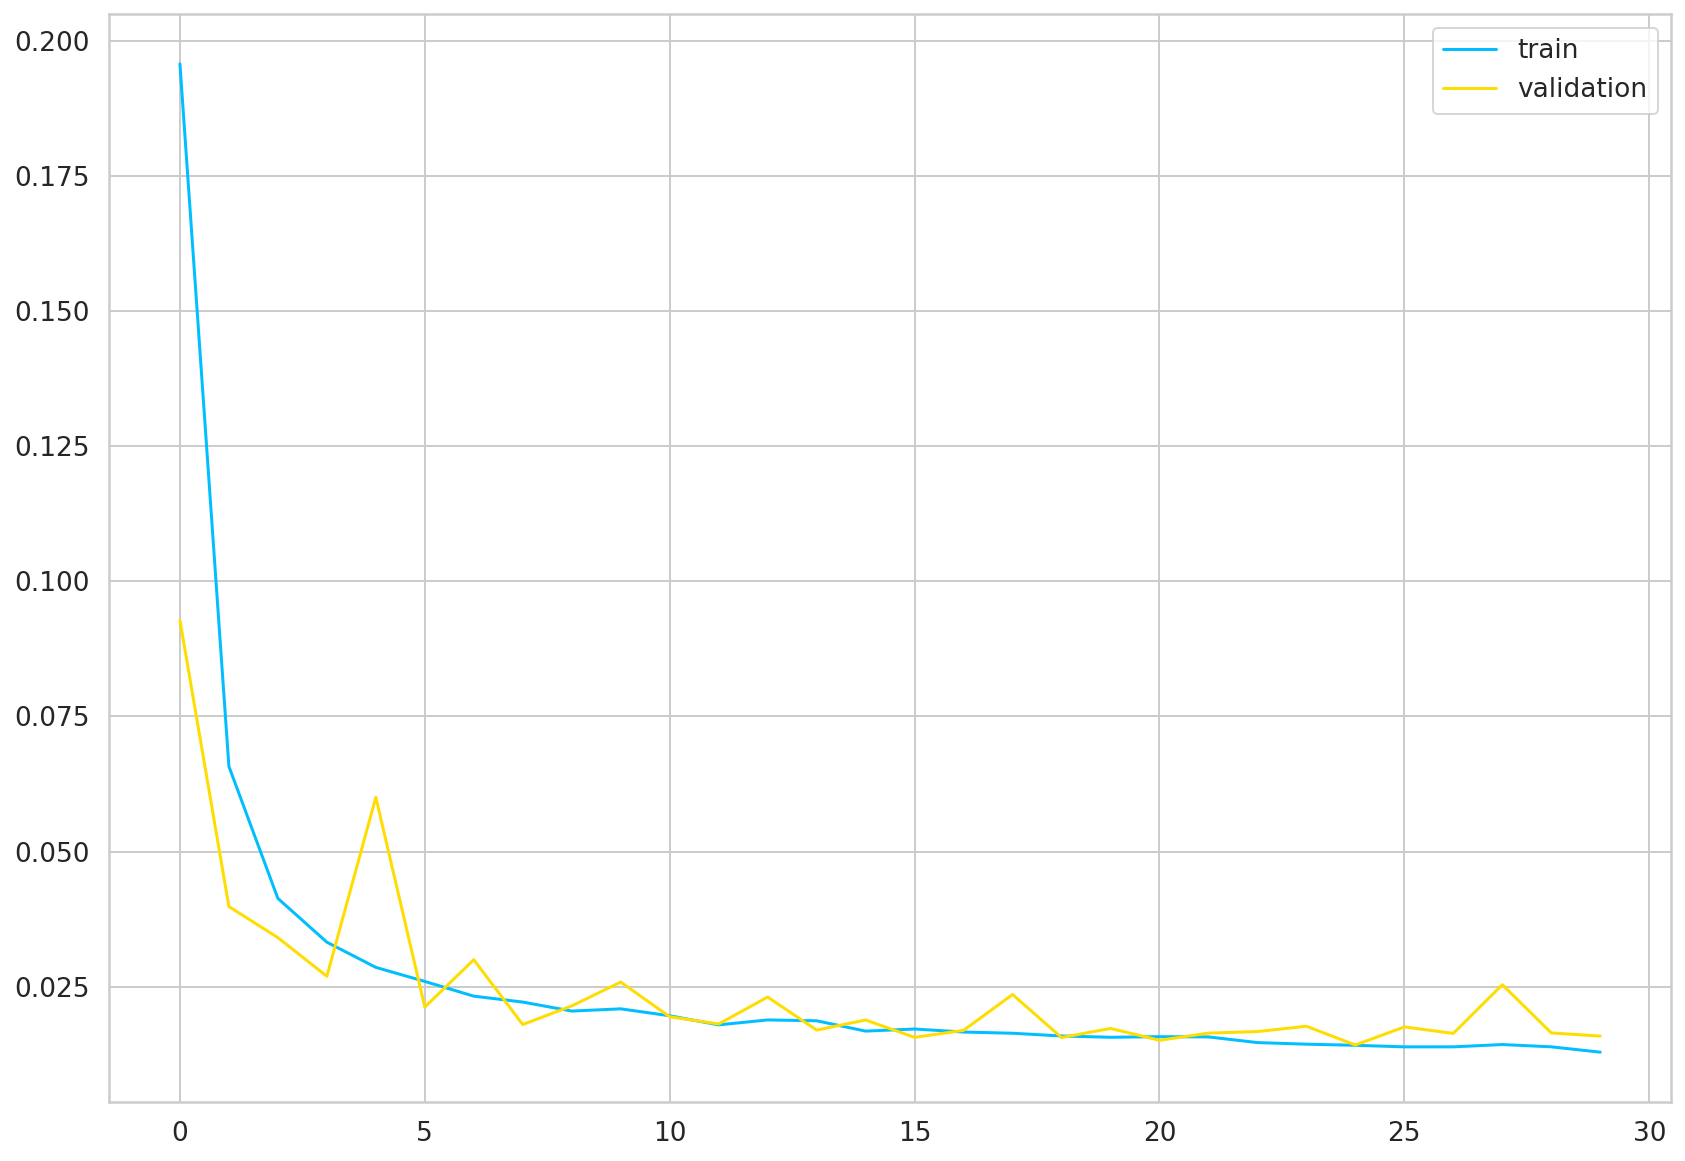

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

In [43]:
y_pred=model.predict(X_test)

In [44]:
y_train_inv=cnt_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv=cnt_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv=cnt_transformer.inverse_transform(y_pred)

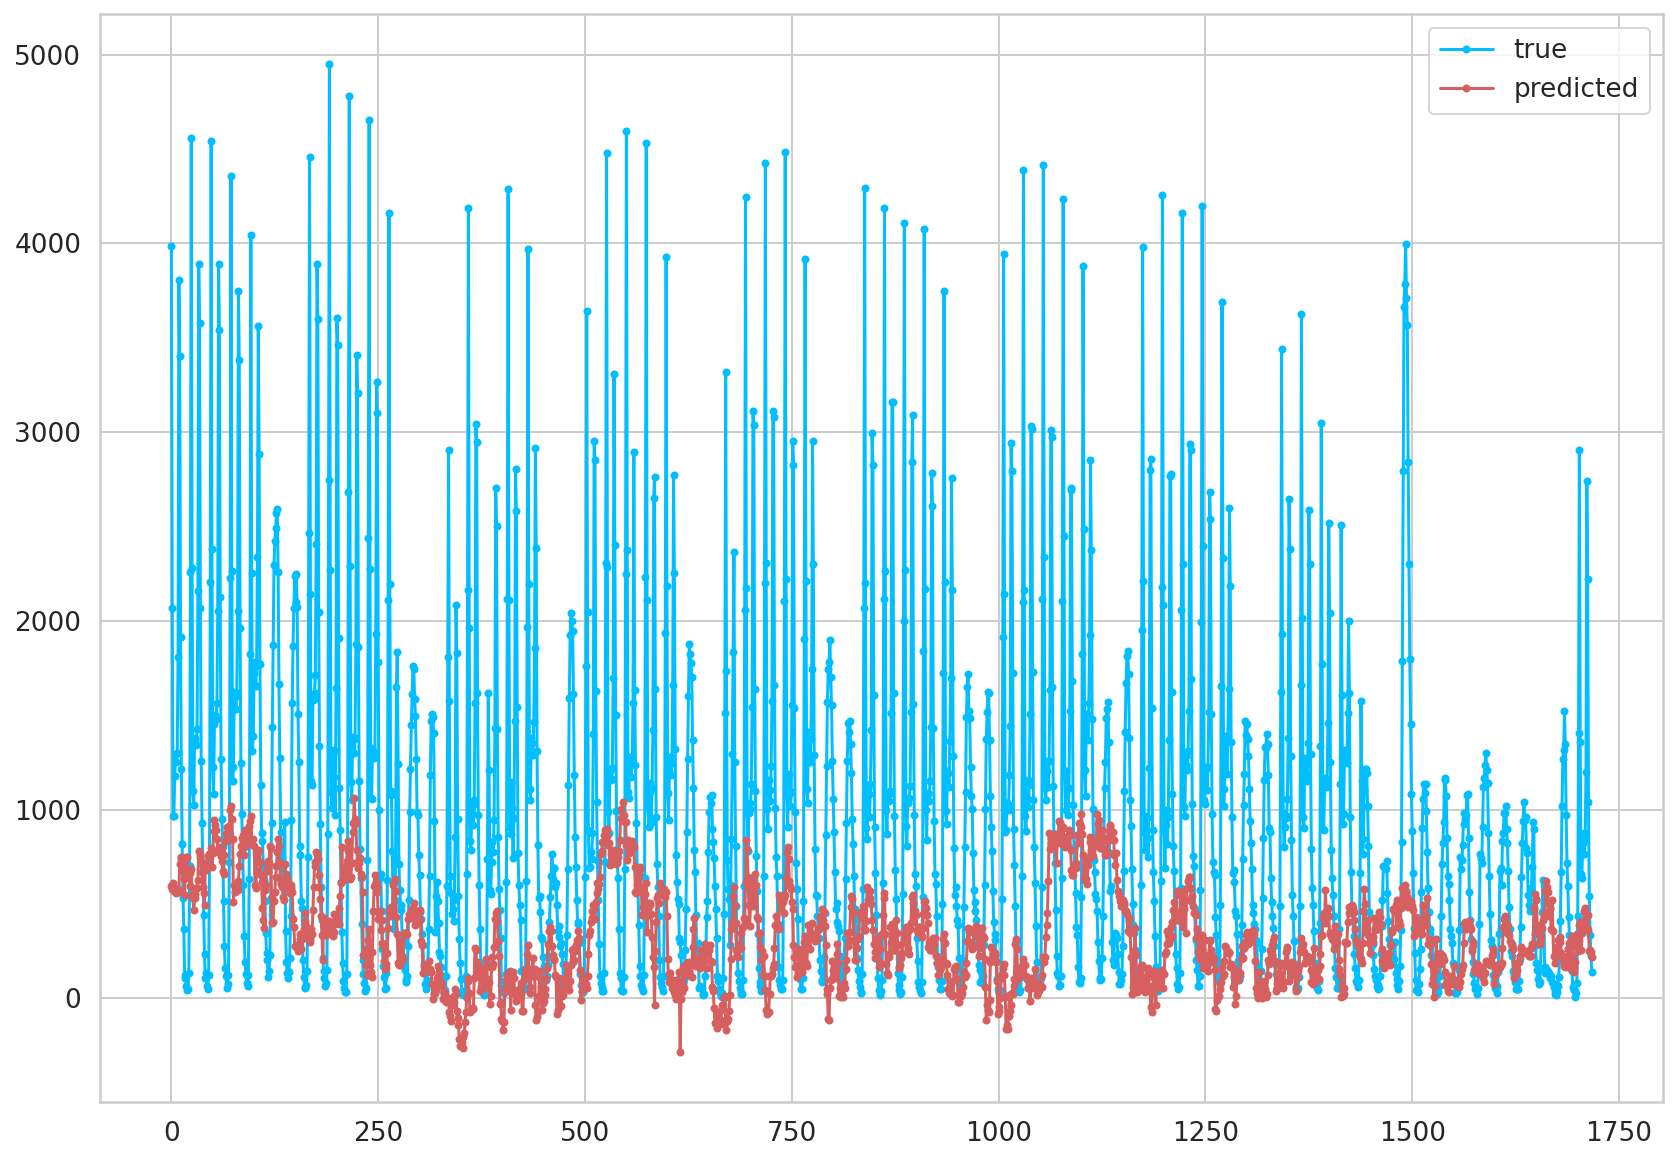

In [45]:
plt.plot(y_test_inv.flatten(), marker='.', label='true')
plt.plot(y_pred_inv.flatten(),'r', marker='.', label='predicted')
plt.legend()